In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
def _pad_to_common_shape(img):
    if(len(img.shape) == 3):
        return np.pad(img, [[1280 - img.shape[0], 0], [0, 0], [0, 0]])
    elif(len(img.shape) == 2):
        return np.pad(img, [[1280 - img.shape[0], 0], [0, 0]])
    

In [3]:
context_name = "17694030326265859208_2340_000_2360_000"
pred_path = f'../{context_name}'
image_path = f'/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_jpg/validation/{context_name}'

cam_extrinsic = np.load('./Parameters/Camera_Param/cam_extrinsic.npy')# shape (5, 4, 4)
cam_intrinsic = np.load('./Parameters/Camera_Param/cam_intrinsic.npy')# shape (3, 4, 4)
cam_distortion = np.load('./Parameters/Camera_Param/cam_distortion.npy') # k1, k2, p1, p2, k3

cam_dict = {
    "img_FRONT" : 0,
    "img_FRONT_LEFT" : 1,
    "img_FRONT_RIGHT" : 2,
    "img_SIDE_LEFT" : 3,
    "img_SIDE_RIGHT" : 4
}
n1 = "FRONT_LEFT"
n2 = "FRONT"

cam_name1 = f"img_{n1}"
cam_name2 = f"img_{n2}"

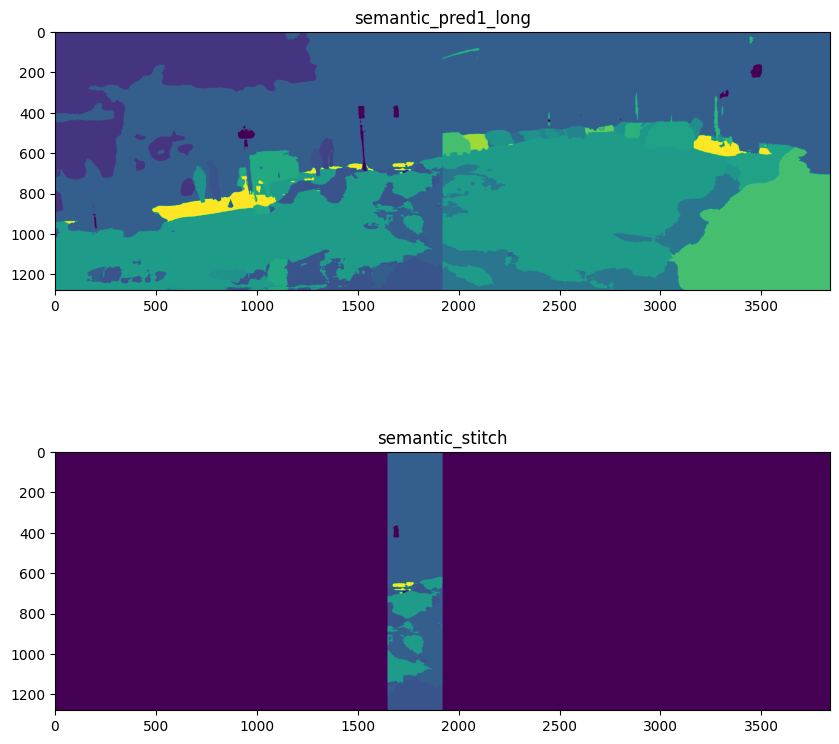

In [17]:
def warpImage(img1, img2, H, addImg1=False):
    img_stitch = cv2.warpPerspective(img2, H, (img2.shape[1]*2, img2.shape[0]))
    if(addImg1):
        img_stitch[0:img1.shape[0], 0:img1.shape[1]] = img1
    return img_stitch

time_stamps = [f for f in os.listdir(pred_path) if os.path.isdir(os.path.join(pred_path, f))]
time_stamps = sorted(time_stamps)
for i, time_stamp in enumerate(time_stamps):
    if(i == 23):
        pred1 = cv2.imread(f"{pred_path}/{time_stamp}/{cam_name1}_panoptic_prediction.png")
        img1 = cv2.imread(f"{image_path}/{time_stamp}/{cam_name1}.jpg")
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        semantic_pred1 = pred1[:, :, 0]
        instance_pred1 = pred1[:, :, 1]
        img1 = _pad_to_common_shape(img1)
        semantic_pred1 = _pad_to_common_shape(semantic_pred1)
        
        pred2 = cv2.imread(f"{pred_path}/{time_stamp}/{cam_name2}_panoptic_prediction.png")
        img2 = cv2.imread(f"{image_path}/{time_stamp}/{cam_name2}.jpg")
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        semantic_pred2 = pred2[:, :, 0]
        instance_pred2 = pred2[:, :, 1]
        img2 = _pad_to_common_shape(img2)
        semantic_pred2 = _pad_to_common_shape(semantic_pred2)
        
        H = np.load(f"./Parameters/Homography/H_{n1}_and_{n2}.npy")
        semantic_warp = warpImage(semantic_pred1, semantic_pred2, H, addImg1=False)
        img_stitch = warpImage(img1, img2, H, addImg1=True)
        
        
        tl = H @ np.array([0, 0, 1])
        tl /= tl[2]
        bl = H @ np.array([0, img2.shape[0], 1])
        bl /= bl[2]
        left_most_of_warpedImg2 = np.floor(min(tl[0], bl[0])).astype(int)
        right_most_of_img1 = img1.shape[1]
        
        sem_overlap1 = np.zeros_like(semantic_stitch)
        sem_overlap1[:, left_most_of_warpedImg2:right_most_of_img1] = semantic_pred1[:, left_most_of_warpedImg2:right_most_of_img1]
        sem_overlap2 = np.zeros_like(semantic_stitch)
        sem_overlap2[:, left_most_of_warpedImg2:right_most_of_img1] = semantic_warp[:, left_most_of_warpedImg2:right_most_of_img1]
        
        fig, axs = plt.subplots(2, 1, figsize=(10, 10))
        
        semantic_pred1_long = np.zeros((img1.shape[0], img1.shape[1]*2))
        semantic_pred1_long[:, : 1920] = semantic_pred1
        
        axs[0].imshow(semantic_stitch)
        axs[0].set_title('semantic_pred1_long')
        
        axs[1].imshow(semantic_stitch_overlapped)
        axs[1].set_title('semantic_stitch')
        
        # axs[1][0].imshow(semantic_stitch)
        # axs[1][0].set_title('semantic_stitch')
        
        # axs[1][1].imshow(semantic_stitch)
        # axs[1][1].set_title('semantic_stitch')

plt.show()